# Heart Failure Prediction - Machine Learning Pipeline

## Project Overview
This notebook demonstrates a comprehensive machine learning workflow to predict heart failure using the [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). 

### Models Evaluated
1. Logistic Regression
2. Support Vector Machine (SVM)
3. Random Forest
4. Gradient Boosting
5. K-Nearest Neighbors (KNN)

In [46]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Basic Exploration

In [47]:
# Load the dataset
df = pd.read_csv('heart.csv')
display(df.head())

df.info()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<class 'pandas.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    str    
 2   ChestPainType   918 non-null    str    
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    str    
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    str    
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    str    
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), str(5)
memory usage: 86.2 KB


In [48]:
# Statistical Summary
display(df.describe(include='all'))

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


## 2. Exploratory Data Analysis (EDA)
Understanding the data distribution and relationships between variables.

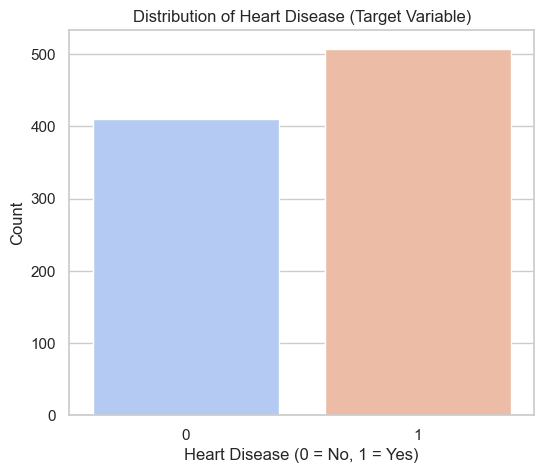

In [49]:
# Target Variable Distribution
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='HeartDisease', data=df, palette='coolwarm', hue='HeartDisease', legend=False)
plt.title('Distribution of Heart Disease (Target Variable)')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

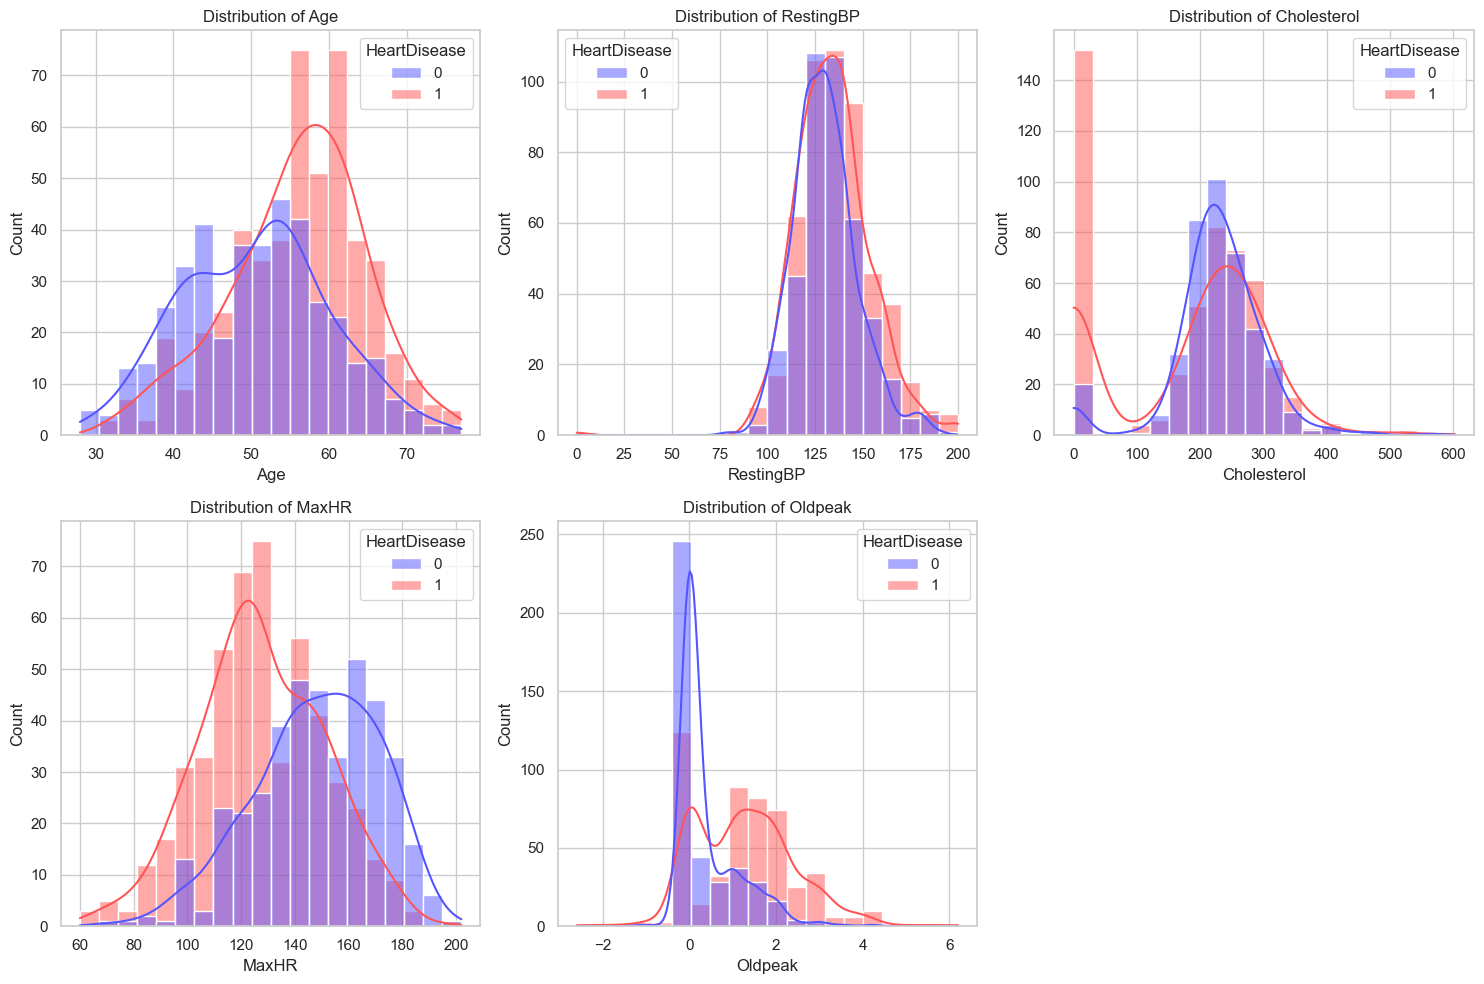

In [50]:
# Separate categorical and numerical columns for plotting
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Plot Numerical Distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df, x=col, hue='HeartDisease', kde=True, palette='seismic', bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

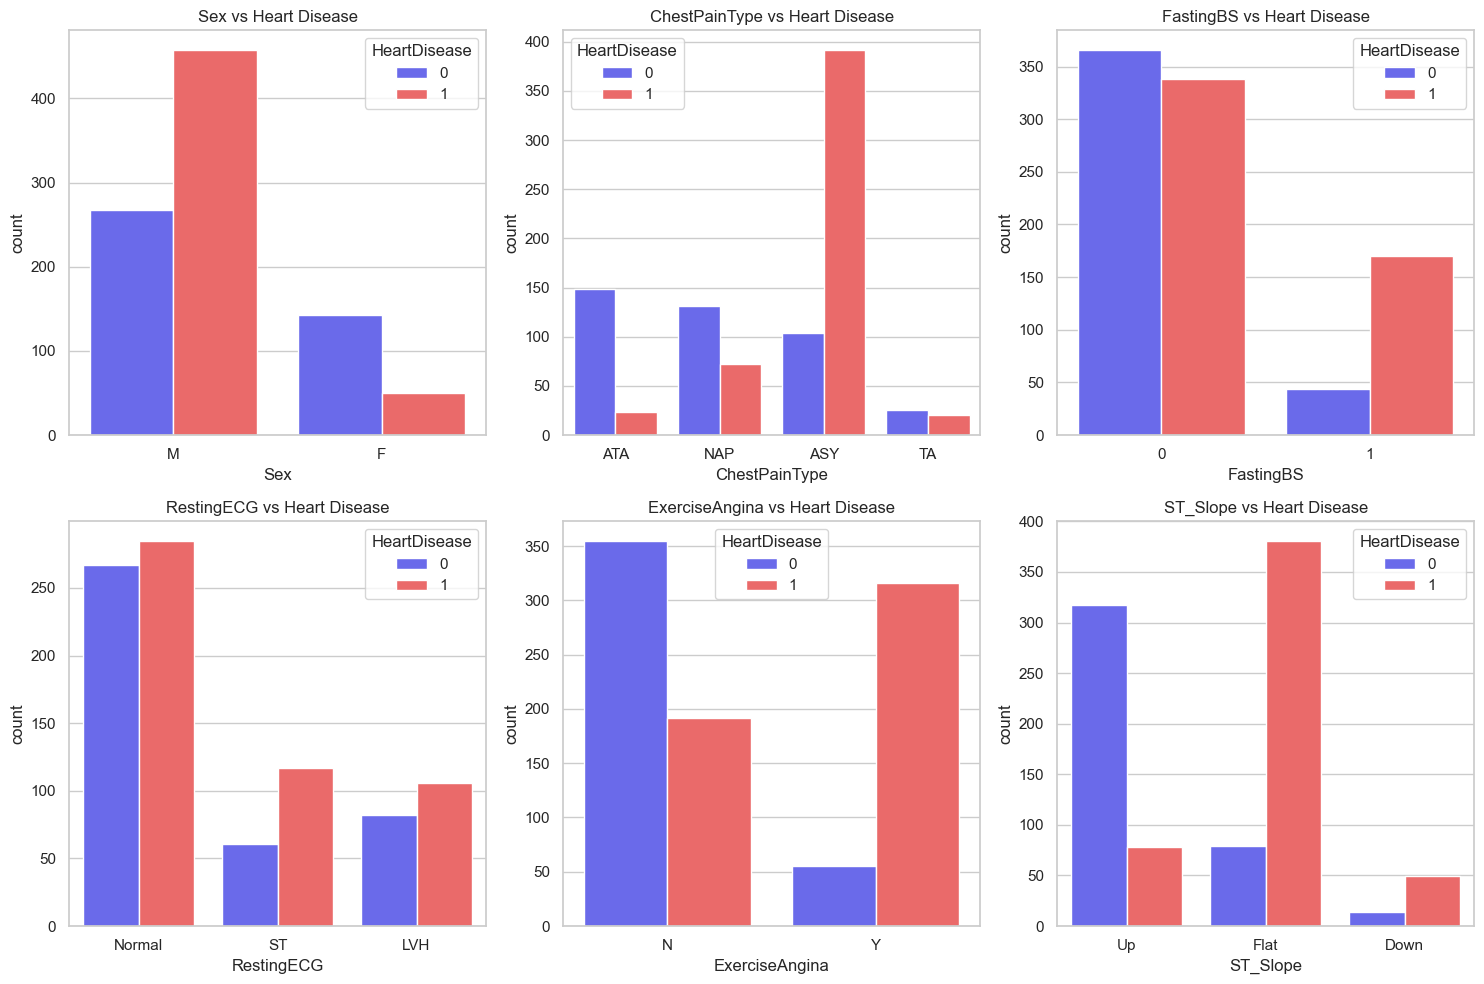

In [51]:
# Plot Categorical Features vs Target
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=col, hue='HeartDisease', palette='seismic')
    plt.title(f'{col} vs Heart Disease')
plt.tight_layout()
plt.show()

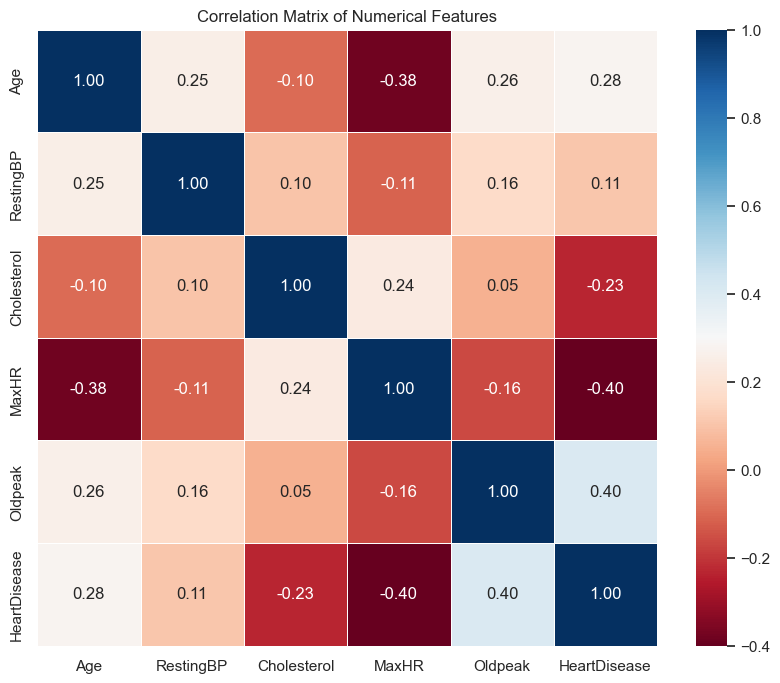

In [52]:
# Correlation Matrix (Numerical Features)
plt.figure(figsize=(10, 8))
corr_matrix = df[num_cols + ['HeartDisease']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 3. Data Preprocessing and Pipeline Selection

We will use `ColumnTransformer` to apply different transformations to numerical and categorical features:
- **Numerical**: Imputation (mean) + Scaling (StandardScaler)
- **Categorical**: Imputation (most frequent) + One-Hot Encoding

In [53]:
# Define features and target
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

# Define Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


Training shape: (734, 11)
Testing shape: (184, 11)


## 4. Modeling and Hyperparameter Tuning

We will train multiple models using `Pipeline` and tune them with `GridSearchCV`.

In [54]:
# Initialize Dictionary to store results
model_performance = {}

# Helper function for GridSearch
def train_evaluate_model(name, model, params):
    print(f"\nTraining {name}...")
    
    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # GridSearch
    grid = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best CV Score: {grid.best_score_:.4f}")
    
    # Test Prediction
    y_pred = grid.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Evaluate
    if hasattr(grid.best_estimator_.named_steps['classifier'], "predict_proba"):
        y_prob = grid.predict_proba(X_test)[:, 1]
    else:
        y_prob = grid.decision_function(X_test)
        
    # Store results
    model_performance[name] = {
        'Best Params': grid.best_params_,
        'CV Accuracy': grid.best_score_,
        'Test Accuracy': test_acc,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'model_obj': grid
    }
    
    return grid

In [55]:
# 1. Logistic Regression
lr_params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

train_evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), lr_params)

# 2. Support Vector Machine
svm_params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__probability': [True]
}

train_evaluate_model("SVM", SVC(), svm_params)

# 3. Random Forest
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

train_evaluate_model("Random Forest", RandomForestClassifier(random_state=42), rf_params)

# 4. Gradient Boosting
gb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5]
}

train_evaluate_model("Gradient Boosting", GradientBoostingClassifier(random_state=42), gb_params)

# 5. K-Nearest Neighbors
knn_params = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13],
    'classifier__weights': ['uniform', 'distance']
}

train_evaluate_model("KNN", KNeighborsClassifier(), knn_params)


Training Logistic Regression...
Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best CV Score: 0.8528
Test Accuracy: 0.8913

Training SVM...
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'classifier__probability': True}
Best CV Score: 0.8637
Test Accuracy: 0.8859

Training Random Forest...
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV Score: 0.8637
Test Accuracy: 0.9076

Training Gradient Boosting...
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best CV Score: 0.8583
Test Accuracy: 0.8750

Training KNN...
Best Parameters: {'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'}
Best CV Score: 0.8624
Test Accuracy: 0.9185


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__n_neighbors': [3, 5, ...], 'classifier__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 

## 5. Model Evaluation and Comparison

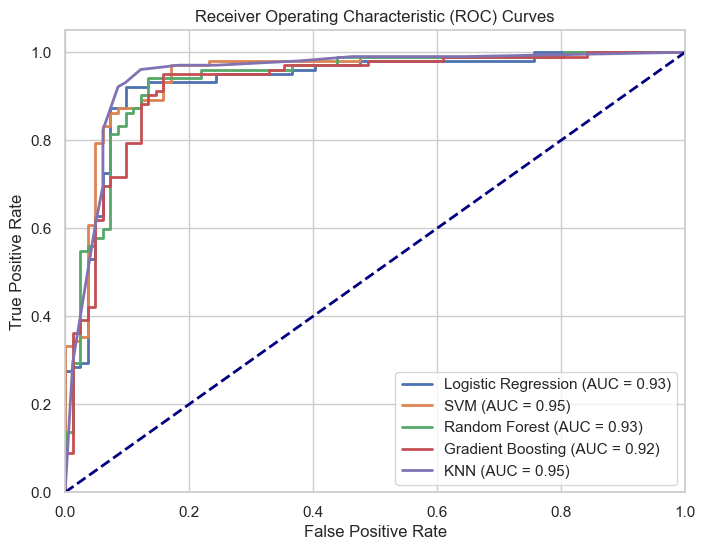

In [56]:
# ROC Curves
plt.figure(figsize=(8, 6))
for name, data in model_performance.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

,CV Accuracy,Test Accuracy
KNN,0.862389,0.918478
Random Forest,0.863722,0.907609
Logistic Regression,0.852791,0.891304
SVM,0.863694,0.88587
Gradient Boosting,0.85827,0.875


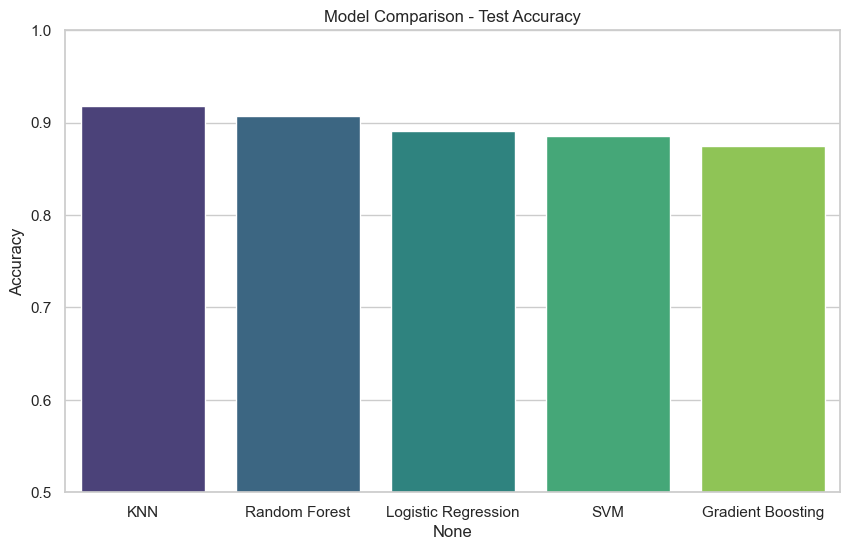

In [57]:
# Create Comparison DataFrame
results_df = pd.DataFrame(model_performance).T[['CV Accuracy', 'Test Accuracy']]
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)
display(results_df)

# Plot Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Test Accuracy', data=results_df, palette='viridis', hue=results_df.index, legend=False)
plt.title('Model Comparison - Test Accuracy')
plt.ylim(0.5, 1.0)
plt.ylabel('Accuracy')
plt.show()